In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd
from estimate import test_mse_pop
import seaborn as sns

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams.update({"font.size": 15})

In [2]:
p = 2
B = np.array([[0, 0],
              [2, 0]])
b_causal = B[-1, :-1]
C = inv(np.eye(p) - B)

# Observational stats
# noise variance
S_eps = np.array([[1, 0.5],
               [0.5, 1]])
# data 
Sigma_0 = C @ S_eps @ C.T
Gram_0 = Sigma_0

# Interventional stats
# Unidentifiable case
mu1_noise = np.array([0.5, 0.1]) # the first component = 0.1 or 0.5
S1 = np.array([[1, 0.1],
                  [0.1, 0.05]])

# Identifiable case
# mu1_noise = np.array([0.5, 0]) # the first component = 0.1 or 0.5
# S1 = np.array([[1, 0],
#                   [0, 0]])

mu1 = C @ mu1_noise
# data
Sigma_1 = C @ (S_eps + S1) @ C.T
Gram_1 = Sigma_1 + np.outer(mu1, mu1)

# Test distribution
gram_v_base = (C @ S1 @ C.T + np.outer(mu1, mu1)) / 2

In [3]:
# Estimations
gamma = 5

# Our approach
M = (Gram_1[:-1, :-1] - Gram_0[:-1, :-1]) * gamma / 2 + Gram_0[:-1, :-1]
N = gamma / 2 * (Gram_1[:-1, -1] - Gram_0[:-1, -1]) + Gram_0[:-1, -1]
b_ours = inv(M) @ N

# Anchor regression
b_anchor = inv(Gram_0[:-1, :-1] + Gram_1[:-1, :-1] + (gamma - 1) * np.outer(mu1[:-1], mu1[:-1])) @ (Gram_0[:-1, -1] + Gram_1[:-1, -1] + (gamma - 1) * mu1[:-1] * mu1[-1])

# Pooled OLS
b_pooled = inv(Sigma_0[:-1, :-1] + Sigma_1[:-1, :-1] + np.outer(mu1[:-1], mu1[:-1])) @ (Sigma_0[:-1, -1] + Sigma_1[:-1, -1] + mu1[:-1] * mu1[-1])

# Observational OLS
b_obs = inv(Sigma_0[:-1, :-1]) @ Sigma_0[:-1, -1]

# Causal solution
b_causal = B[-1, :-1]


# Loop through perturbation strengths
perturb_stren = np.linspace(0, 15, 15)

mse_ours = []
mse_anchor = []
mse_pooled = []
mse_obs = []
mse_causal = []

for l in perturb_stren:
    Gram_t = Gram_0 + l * gram_v_base
    mse_ours.append(test_mse_pop(Gram_t, b_ours))
    mse_anchor.append(test_mse_pop(Gram_t, b_anchor))
    mse_obs.append(test_mse_pop(Gram_t, b_obs))
    mse_pooled.append(test_mse_pop(Gram_t, b_pooled))
    mse_causal.append(test_mse_pop(Gram_t, b_causal))

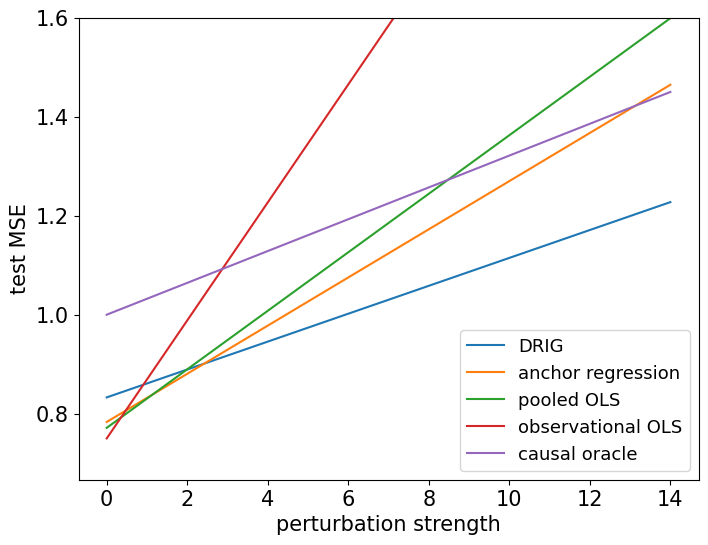

In [4]:
x = np.arange(len(perturb_stren))
plt.plot(x, mse_ours, label="DRIG")
plt.plot(x, mse_anchor, label="anchor regression")
plt.plot(x, mse_pooled, label="pooled OLS")
plt.plot(x, mse_obs, label="observational OLS")
plt.plot(x, mse_causal, label="causal oracle")

plt.xlabel("perturbation strength")
plt.ylabel("test MSE")
plt.legend(loc="best", fontsize=13)
plt.ylim(top=1.6)
# plt.savefig("./results/illus-unid.pdf", bbox_inches="tight")
plt.show()